In [1]:
recalculate = True

In [2]:
import os
import re
import json
import math
import pickle
import numpy as np
import pandas as pd
import datetime as dt
import multiprocessing as mp
from tqdm import tqdm
from multiprocessing import Pool
from datetime import timezone
from datetime import timedelta
from pprint import pprint

# Plots
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [15, 9]

import config
from config import load_us_city_state_files
city_to_state_dict, abbrev_to_state_dict, state_to_state_dict = load_us_city_state_files()

from config import load_friends_dictionary
friends_dictionary = load_friends_dictionary()

{'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "givenchy's death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away']},
 'path': {'cwd': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy',
          'friends_dictionary': '/Users/lzhou/git/github/uclresearchanalysis/other/friends_dictionary.dat',
          'pickle': {'network_dataframe': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/network.dat',
                     'tweets_dataframe': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/tweets.dat',
                     'users_dataframe': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/users.dat'},
          'result': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/result',
          'twitter': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/twitter'},
 'timeframe': '1440'}
'Load city and state dictionaries from dat files'
'loaded 102 states abbre

In [3]:
file_input_path = config.settings['path']['twitter']
dates = config.settings['data']['dates']
search_phrases = config.settings['data']['phrases']
timeframe = config.settings['timeframe']
project_name = config.settings['data']['eventname']

In [4]:
def order_and_reindex(df, column):
    df = df.sort_values(by=[column])
    df = df.set_index(np.arange(len(df.index)))
    return df

## Unique Tweets

In [5]:
def convert_utc_to_est(time_string):
    datetime_object = dt.datetime.strptime(time_string, '%a %b %d %H:%M:%S %z %Y')
    return datetime_object.replace(tzinfo=timezone.utc).astimezone(tz=timezone(-timedelta(hours=5)))

def get_created_at(tweet):
    return convert_utc_to_est(tweet['created_at'])

def get_retweet_id(tweet):
    if (tweet['text'].split()[0] == 'RT'):
        user_name = tweet['text'].split()[1][1:-1]
        mentions = tweet['entities']['user_mentions']
        for mention in mentions:
            if mention['screen_name'] == user_name:
                return string_to_int(mention['id'])

def get_reply_id(tweet):
    return string_to_int(tweet['in_reply_to_user_id_str'])
    
def get_user_mentions(tweet):
    retweet_id = get_retweet_id(tweet)
    reply_id = get_reply_id(tweet)  
    mentions = []
    for mention in tweet['entities']['user_mentions']:
        mention_id = string_to_int(mention['id'])
        if mention_id != retweet_id and mention_id != reply_id:
            mentions.append(mention_id)
    return mentions

def string_to_int(string):
    if string is None:
        return None
    else:
        return int(string)

def find_unique_tweets_crawled():
    file_path_dict = {
        date: ['{}/{}_{}.json'.format(file_input_path, x, date) for x in search_phrases]
        for date in dates
    }
    tweets_crawled_list = []
    for date, file_path_list in file_path_dict.items():
        for file_path in file_path_list:
            if (os.path.isfile(file_path)):
                with open(file_path, 'r') as file:
                    counter = 0
                    for line in file.readlines():
                        tweets_crawled_list.append(json.loads(line))
                        counter += 1
                    print('{}, {}, {}'.format(date, file_path, counter))
    print(tweets_crawled_list[0]['entities']['user_mentions'])
    
    unique_tweets = list({each['id']:each for each in tweets_crawled_list}.values())
    
    df = pd.DataFrame()
    df['user'] = list(map(lambda tweet: tweet['user']['screen_name'], unique_tweets))
    df['user_id'] = list(map(lambda tweet: string_to_int(tweet['user']['id_str']), unique_tweets))
    df['created_at'] = list(map(lambda tweet: get_created_at(tweet), unique_tweets))
    df['followers_count'] = list(map(lambda tweet: int(tweet['user']['followers_count']), unique_tweets))
    df['friends_count'] = list(map(lambda tweet: int(tweet['user']['friends_count']), unique_tweets))
    df['reply_id'] = list(map(lambda tweet: get_reply_id(tweet), unique_tweets))
    df['retweet_id'] = list(map(lambda tweet: get_retweet_id(tweet), unique_tweets))
    df['at_ids'] = list(map(lambda tweet: get_user_mentions(tweet), unique_tweets))
    df['text'] = list(map(lambda tweet: tweet['text'], unique_tweets))
    
    
    df = order_and_reindex(df, 'created_at')
    df['time'] = 0
    first_tweet_datetime = df.created_at.iloc[0]
    for index in tqdm(range(len(df))):
        df.loc[index, 'time'] = round((df.loc[index, 'created_at'] - first_tweet_datetime).total_seconds() / 60.0, 2)
    df = df[df.time < float(timeframe)]
    return df

In [6]:
if recalculate:
    unique_tweets = find_unique_tweets_crawled()
    print(unique_tweets.head())
    with open(config.settings['path']['pickle']['tweets_dataframe'], 'wb') as tweets_dataframe_file:
        pickle.dump(unique_tweets, tweets_dataframe_file)

2018-03-11, /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/twitter/givenchy%20death_2018-03-11.json, 0
2018-03-11, /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/twitter/givenchy%20passed%20away_2018-03-11.json, 0
2018-03-12, /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/twitter/givenchy%20death_2018-03-12.json, 216
2018-03-12, /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/twitter/givenchy%20passed%20away_2018-03-12.json, 4263
2018-03-13, /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/twitter/givenchy%20death_2018-03-13.json, 68
2018-03-13, /Users/lzhou/git/github/uclresearchanalysis/data/givenchy/twitter/givenchy%20passed%20away_2018-03-13.json, 898
[{'indices': [3, 19], 'name': 'Fashionista.com', 'id': 15933910, 'id_str': '15933910', 'screen_name': 'Fashionista_com'}]


100%|██████████| 5421/5421 [00:03<00:00, 1590.96it/s]


             user     user_id                created_at  followers_count  \
0      davelackie   100766356 2018-03-12 08:20:58-05:00           143119   
1  alexanderskhan  3186545203 2018-03-12 08:21:07-05:00              753   
2   consiglierela  4134992843 2018-03-12 08:21:12-05:00             2161   
3  ImpactPrincess  1955472014 2018-03-12 08:21:36-05:00              242   
4     Damek0Masca   406301175 2018-03-12 08:22:06-05:00              116   

   friends_count  reply_id   retweet_id at_ids  \
0           4643       NaN          NaN     []   
1           3428       NaN  100766356.0     []   
2            396       NaN  100766356.0     []   
3            642       NaN  100766356.0     []   
4            239       NaN          NaN     []   

                                                text  time  
0  So sad to hear that fashion designer Hubert de...  0.00  
1  RT @davelackie: So sad to hear that fashion de...  0.15  
2  RT @davelackie: So sad to hear that fashion de...  0.23 

In [7]:
with open(config.settings['path']['pickle']['tweets_dataframe'], 'rb') as tweets_dataframe_file:
        unique_tweets = pickle.load(tweets_dataframe_file)
        pprint('Loaded {} entries'.format(len(unique_tweets)))

'Loaded 5181 entries'


# Unique Users

In [8]:
def find_by_user_name(df, user_name):
    user = df[df.user == user_name]
    return user.iloc[0]

def find_by_user_id(df, user_id):
    user = df[df.user_id == user_id]
    return user.iloc[0]

def find_unique_users():
    df = unique_tweets.copy()
    df = df.drop_duplicates(subset = ['user_id'])
    df = df.loc[:,['user', 'user_id', 'time', 'followers_count', 'friends_count']]
    df['source_candidates'] = [set([]) for _ in range(len(df))]
    df = order_and_reindex(df, 'time')
    
    unique_user_id_set = set([int(x) for x in df.user_id])
    
    for index in tqdm(range(len(unique_tweets))):
        user_name = unique_tweets.loc[index, 'user']
        user_id = unique_tweets.loc[index, 'user_id']
        reply_id = unique_tweets.loc[index, 'reply_id']
        retweet_id = unique_tweets.loc[index, 'retweet_id']
        at_ids = unique_tweets.loc[index, 'at_ids']
        
        if reply_id is not None:
            if reply_id in unique_user_id_set:
                try:
                    find_by_user_id(df, user_id).source_candidates.add(int(reply_id))
                except:
                    pass
        if retweet_id is not None:
            if retweet_id in unique_user_id_set:
                try:
                    find_by_user_id(df, user_id).source_candidates.add(int(retweet_id))
                except:
                    pass
        for at_id in at_ids:
            if at_id in unique_user_id_set:
                try:
                    find_by_user_id(df, at_id).source_candidates.add(int(user_id))
                except IndexError:
                    pass
            
    friends_not_found_list = []
    for index in tqdm(range(len(df))):
        user_id = str(df.loc[index, 'user_id'])
        try:
            friends = set(friends_dictionary[user_id]) & unique_user_id_set
            df.loc[index, 'source_candidates'].update(friends)
        except KeyError:
            friends_not_found_list.append(index)
    print('Could not load friends for {}/{} entries'.format(len(friends_not_found_list), len(df)))
    return df

In [9]:
if recalculate:
    unique_users = find_unique_users()
    print(unique_users.head())
    with open(config.settings['path']['pickle']['users_dataframe'], 'wb') as users_dataframe_file:
        pickle.dump(unique_users, users_dataframe_file)

100%|██████████| 5011/5011 [00:00<00:00, 10732.63it/s]

Could not load friends for 1/5011 entries
             user     user_id  time  followers_count  friends_count  \
0      davelackie   100766356  0.00           143119           4643   
1  alexanderskhan  3186545203  0.15              753           3428   
2   consiglierela  4134992843  0.23             2161            396   
3  ImpactPrincess  1955472014  0.63              242            642   
4     Damek0Masca   406301175  1.13              116            239   

                                   source_candidates  
0  {720792291649171456, 719864872767463424, 97251...  
1                                        {100766356}  
2  {1286631812, 503988356, 525805387, 2471206543,...  
3                  {100766356, 2889413549, 42921639}  
4                                                 {}  


In [10]:
with open(config.settings['path']['pickle']['users_dataframe'], 'rb') as users_dataframe_file:
        unique_users = pickle.load(users_dataframe_file)
        pprint('Loaded {} entries'.format(len(unique_users)))

'Loaded 5011 entries'


# Calculate Network

In [11]:
def find_source(df, index):
    time_created = df.loc[index, 'time']
    try:
        candidate = df[df.user_id.isin(df.loc[index, 'source_candidates'])].iloc[0]
    except IndexError:
        return np.NaN
    if time_created > candidate.time:
        return candidate.user_id
    else:
        return np.NaN
    
def find_root_and_generation(df, index):
    row = df.iloc[index]
    time = row.time
    source = row.source_id
    generation = int(0)
    while ~np.isnan(source):
        row = df[df.user_id == source].iloc[0]
        source = row.source_id
        generation += 1
    root_time = row.time
    return (row.user_id, generation, time-root_time)
    
    
def find_network():
    df = unique_users.copy()
    df['source_id'] = [np.NaN for _ in range(len(df))]
    for index in tqdm(reversed(range(len(df)))):
        df.loc[index, 'source_id'] = find_source(unique_users, index)
    df = df.loc[:, ['user', 'user_id', 'source_id', 'time', 'followers_count', 'friends_count']]
    
    df['seed_user_id'] = [np.NaN for _ in range(len(df))]
    df['generation'] = [np.NaN for _ in range(len(df))]
    df['time_since_seed'] = [np.NaN for _ in range(len(df))]
    for index in tqdm(range(len(df))):
        df.loc[index, 'seed_user_id'], df.loc[index, 'generation'], df.loc[index, 'time_since_seed']= find_root_and_generation(df, index)
    return df

In [12]:
network = find_network()
network.head()

5011it [00:07, 633.04it/s]
100%|██████████| 5011/5011 [00:15<00:00, 329.50it/s]


,user,user_id,source_id,time,followers_count,friends_count,seed_user_id,generation,time_since_seed
0,davelackie,100766356,NaN,0.00,143119,4643,100766356.0,0.0,0.00
1,alexanderskhan,3186545203,100766356.0,0.15,753,3428,100766356.0,1.0,0.15
2,consiglierela,4134992843,100766356.0,0.23,2161,396,100766356.0,1.0,0.23
3,ImpactPrincess,1955472014,100766356.0,0.63,242,642,100766356.0,1.0,0.63
4,Damek0Masca,406301175,NaN,1.13,116,239,406301175.0,0.0,0.00


In [13]:
with open(config.settings['path']['pickle']['network_dataframe'], 'wb') as network_dataframe_file:
    pickle.dump(network, network_dataframe_file)

# Analysis

In [14]:
plt.rcParams['figure.figsize'] = [15, 9]

/Users/lzhou/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


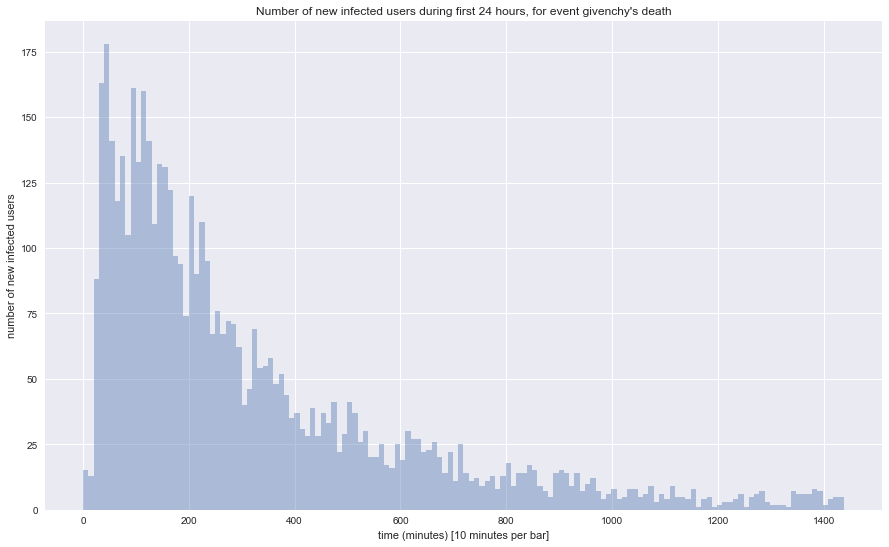

In [15]:
def plot_hist_spreading_graph(df):
    title = 'Number of new infected users during first 24 hours, for event {}'.format(project_name)
    n_bins = math.floor(float(timeframe)/10)
    sns.distplot(df['time'], kde=False, bins=n_bins)
    plt.title(title)
    plt.xlabel('time (minutes) [10 minutes per bar]')
    plt.ylabel('number of new infected users')
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()

plot_hist_spreading_graph(network)

/Users/lzhou/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


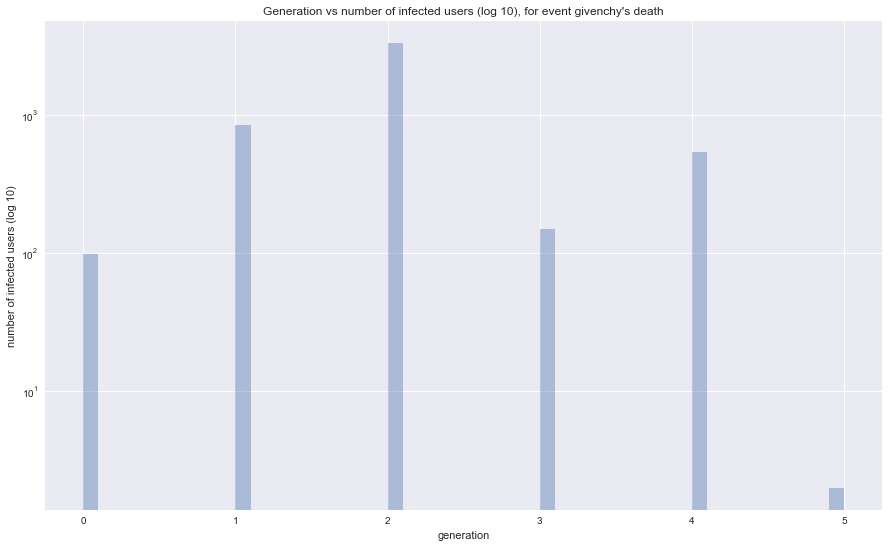

            user  user_id  source_id  time  followers_count  friends_count  \
generation                                                                   
0.0           98       98          0    98               98             98   
1.0          850      850        850   850              850            850   
2.0         3365     3365       3365  3365             3365           3365   
3.0          151      151        151   151              151            151   
4.0          545      545        545   545              545            545   
5.0            2        2          2     2                2              2   

            seed_user_id  time_since_seed  
generation                                 
0.0                   98               98  
1.0                  850              850  
2.0                 3365             3365  
3.0                  151              151  
4.0                  545              545  
5.0                    2                2  


In [16]:
def plot_generation_vs_log_number_of_infected_users(df):
    title = 'Generation vs number of infected users (log 10), for event {}'.format(project_name)
#     n_bins = math.floor(float(timeframe)/10)
    sns.distplot(df['generation'], kde=False, hist_kws={'log':True})
    plt.title(title)
    plt.xlabel('generation')
    plt.ylabel('number of infected users (log 10)')
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()
    
    print(df.groupby('generation').count())

plot_generation_vs_log_number_of_infected_users(network)

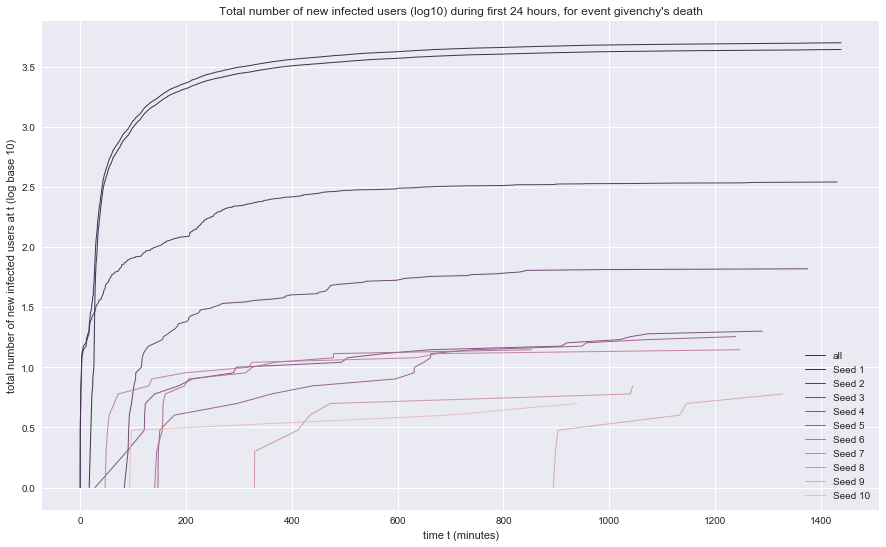

In [17]:
def plot_log_spreading_graph(df):
    title = 'Total number of new infected users (log10) during first 24 hours, for event {}'.format(project_name)
    number_of_seeds = 10
    seed_count_series = df.seed_user_id.value_counts()
    pallttes = sns.cubehelix_palette(number_of_seeds + 1)

    draw_dataframe = df.copy()
    draw_dataframe = draw_dataframe.filter(items=['time'])
    draw_dataframe = draw_dataframe.reset_index()
    draw_dataframe['counter'] = np.log10(range(1, len(draw_dataframe) + 1))
    plt.plot(draw_dataframe['time'], draw_dataframe['counter'], marker='', color=pallttes[number_of_seeds], linewidth=1, alpha=0.9, label = 'all')

    for index in range(number_of_seeds):
        seed_user_id = seed_count_series.keys()[index]
        data_to_plot = df.copy()
        data_to_plot = data_to_plot[data_to_plot.seed_user_id == seed_user_id]['time']
        data_to_plot = data_to_plot.reset_index()
        data_to_plot['counter'] = np.log10(range(1, len(data_to_plot) + 1))
        plt.plot(data_to_plot['time'], data_to_plot['counter'], marker='', color=pallttes[number_of_seeds - index], linewidth=1, alpha=0.9, label='Seed {}'.format(index + 1))

    plt.title(title)
    plt.xlabel('time t (minutes)')
    plt.ylabel('total number of new infected users at t (log base 10)')
    plt.legend()
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()
    
plot_log_spreading_graph(network)

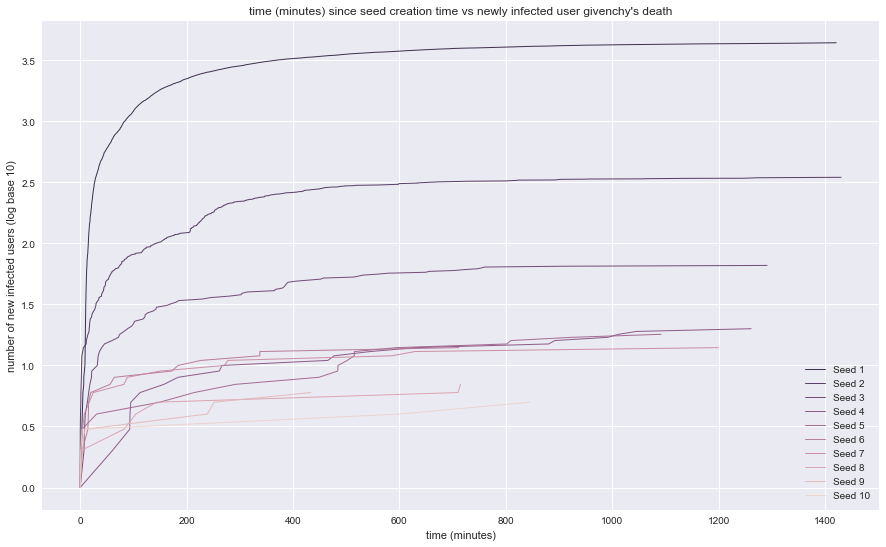

In [18]:
def plot_time_after_spreading_vs_log_10_number_of_newly_infected_user(df):
    title = 'time (minutes) since seed creation time vs newly infected user {}'.format(project_name)
    number_of_seeds = 10
    seed_count_series = df.seed_user_id.value_counts()
    pallttes = sns.cubehelix_palette(number_of_seeds)
    
    for index in range(number_of_seeds):
        seed_user_id = seed_count_series.keys()[index]
        data_to_plot = df.copy()
        data_to_plot = data_to_plot[data_to_plot.seed_user_id == seed_user_id]['time_since_seed']
        data_to_plot = data_to_plot.reset_index()
        data_to_plot['counter'] = np.log10(range(1, len(data_to_plot) + 1))
        plt.plot(data_to_plot['time_since_seed'], data_to_plot['counter'], marker='', color=pallttes[number_of_seeds - index - 1], linewidth=1, alpha=0.9, label='Seed {}'.format(index + 1))

    plt.title(title)
    plt.xlabel('time (minutes)')
    plt.ylabel('number of new infected users (log base 10)')
    plt.legend()
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()
    
plot_time_after_spreading_vs_log_10_number_of_newly_infected_user(network)

/Users/lzhou/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


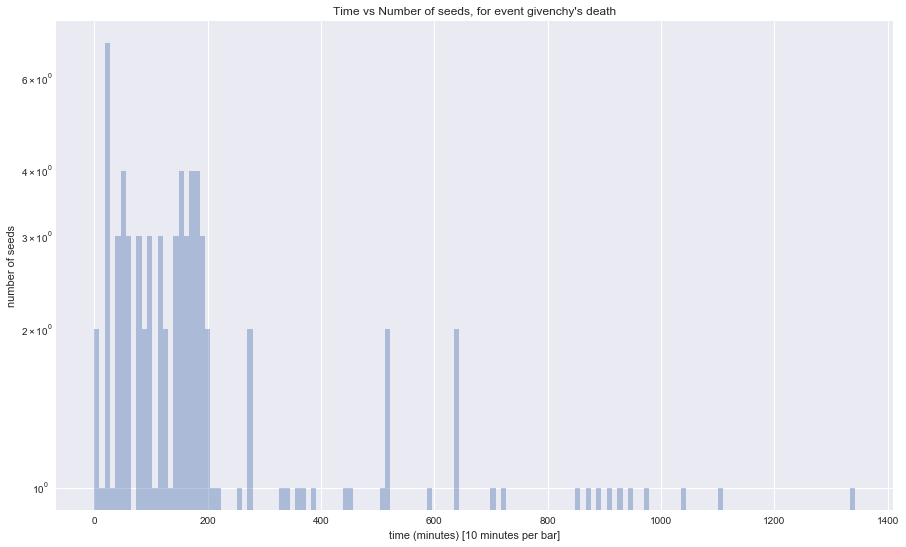

In [19]:
def plot_time_vs_number_of_seeds():
    title = 'Time vs Number of seeds, for event {}'.format(project_name)
    seed_count_series = network.seed_user_id.value_counts()
    seeds_dataframe = network[network.user_id.isin(seed_count_series.keys())].copy()
    seeds_dataframe = order_and_reindex(seeds_dataframe, 'time')
    n_bins = math.floor(float(timeframe)/10)
    sns.distplot(seeds_dataframe['time'], kde=False, bins=n_bins, hist_kws={'log':True})
    plt.title(title)
    plt.xlabel('time (minutes) [10 minutes per bar]')
    plt.ylabel('number of seeds')
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()

plot_time_vs_number_of_seeds()

/Users/lzhou/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


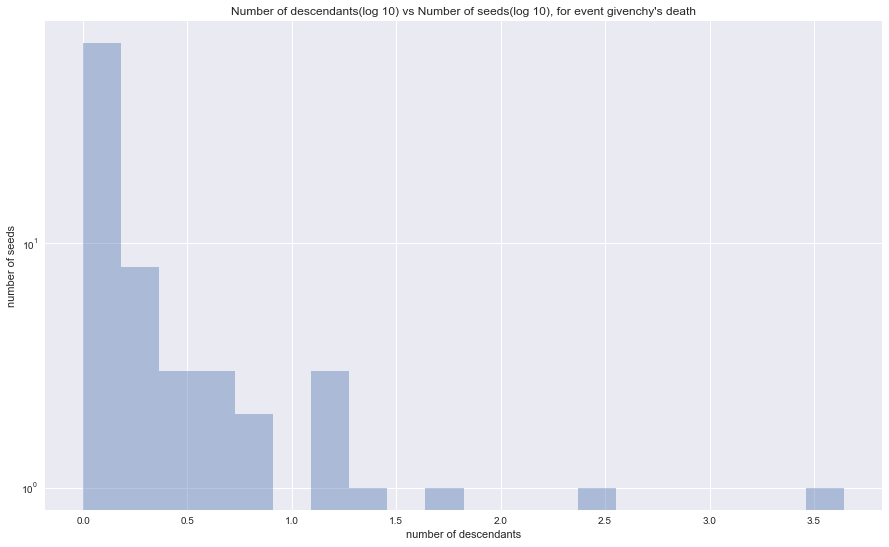

In [20]:
def plot_time_vs_number_of_seeds():
    title = 'Number of descendants(log 10) vs Number of seeds(log 10), for event {}'.format(project_name)
    seed_count_series = network.seed_user_id.value_counts()
    seeds_dataframe = network[network.user_id.isin(seed_count_series.keys())].copy()
    seeds_dataframe = order_and_reindex(seeds_dataframe, 'time')
    seeds_dataframe['y'] = 0
    for index in range(len(seeds_dataframe)):
        userid = seeds_dataframe.loc[index, 'user_id']
        seeds_dataframe.loc[index, 'y'] = np.log10(seed_count_series.get(userid))
    
    n_bins = 20
    
    sns.distplot(seeds_dataframe['y'], kde=False, bins=n_bins, hist_kws={'log':True})
    
#     sns.distplot(seeds_dataframe['y'], kde=False, bins=n_bins)
    plt.title(title)
    plt.xlabel('number of descendants')
    plt.ylabel('number of seeds')
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()

plot_time_vs_number_of_seeds()

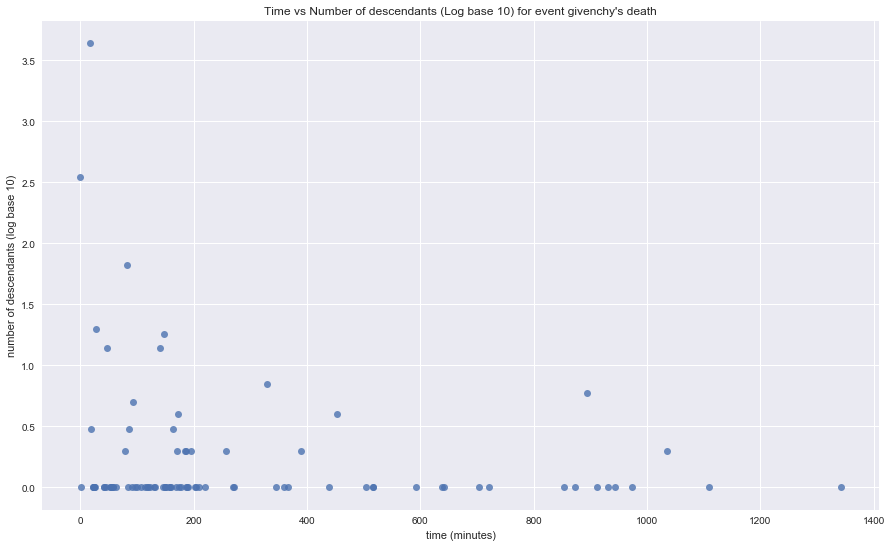

In [21]:
def plot_time_vs_log_seed_descedants():
    title = 'Time vs Number of descendants (Log base 10) for event {}'.format(project_name)
    seed_count_series = network.seed_user_id.value_counts()
    seeds_dataframe = network[network.user_id.isin(seed_count_series.keys())].copy()
    seeds_dataframe = order_and_reindex(seeds_dataframe, 'time')
    seeds_dataframe['y'] = 0
    for index in range(len(seeds_dataframe)):
        userid = seeds_dataframe.loc[index, 'user_id']
        seeds_dataframe.loc[index, 'y'] = np.log10(seed_count_series.get(userid))
    seeds_dataframe.head()

    # use the function regplot to make a scatterplot
    sns.regplot(x=seeds_dataframe["time"], y=seeds_dataframe['y'], fit_reg=False)
    plt.title(title)
    plt.xlabel('time (minutes)')
    plt.ylabel('number of descendants (log base 10)')
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()

plot_time_vs_log_seed_descedants()

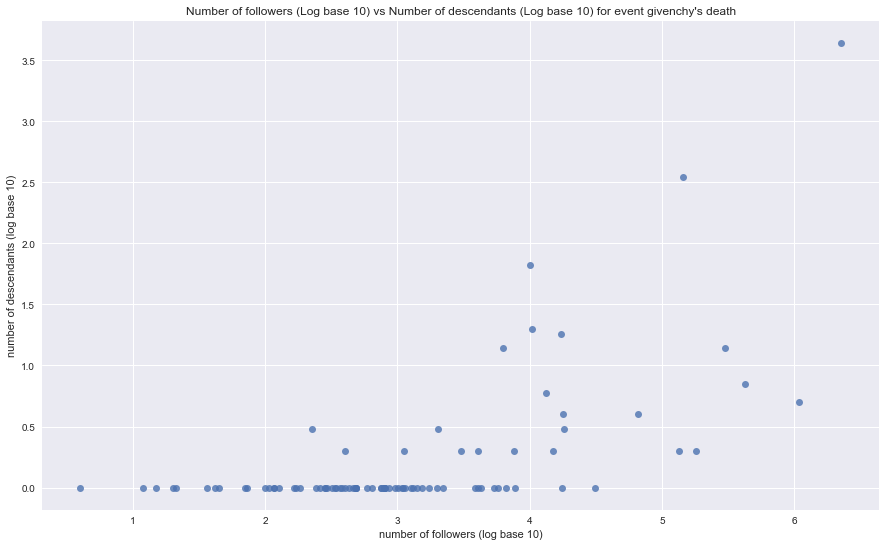

In [22]:
def plot_followers_vs_log_seed_descedants():
    title = 'Number of followers (Log base 10) vs Number of descendants (Log base 10) for event {}'.format(project_name)
    seed_count_series = network.seed_user_id.value_counts()
    seeds_dataframe = network[network.user_id.isin(seed_count_series.keys())].copy()
    seeds_dataframe = order_and_reindex(seeds_dataframe, 'time')
    seeds_dataframe['y'] = 0
    for index in range(len(seeds_dataframe)):
        userid = seeds_dataframe.loc[index, 'user_id']
        seeds_dataframe.loc[index, 'y'] = seed_count_series.get(userid)
    
    # use the function regplot to make a scatterplot
    sns.regplot(
        x=np.log10(seeds_dataframe["followers_count"]), 
        y=np.log10(seeds_dataframe['y']), 
        fit_reg=False)
    plt.title(title)
    plt.xlabel('number of followers (log base 10)')
    plt.ylabel('number of descendants (log base 10)')
    plt.savefig('{}/{}'.format(config.settings['path']['result'], title))
    plt.show()
plot_followers_vs_log_seed_descedants();

In [23]:
def get_details_of_top_10_seeds():
    seed_count_series = network.seed_user_id.value_counts()
    seeds_dataframe = network[network.user_id.isin(seed_count_series.keys())].copy()
    seeds_dataframe = order_and_reindex(seeds_dataframe, 'time')
    seeds_dataframe['number_of_descendants'] = 0
    for index in range(len(seeds_dataframe)):
        userid = seeds_dataframe.loc[index, 'user_id']
        seeds_dataframe.loc[index, 'number_of_descendants'] = seed_count_series.get(userid)
    seeds_dataframe = seeds_dataframe.sort_values(by='number_of_descendants', ascending=False)
    seeds_dataframe = seeds_dataframe.set_index(np.arange(len(seeds_dataframe.index)))
    seeds_dataframe = seeds_dataframe.loc[:10, ['user', 'time', 'followers_count', 'number_of_descendants']]
    print(seeds_dataframe.to_latex())
get_details_of_top_10_seeds()

\begin{tabular}{llrrr}
\toprule
{} &             user &    time &  followers\_count &  number\_of\_descendants \\
\midrule
0  &  Fashionista\_com &   17.00 &          2254291 &                   4405 \\
1  &       davelackie &    0.00 &           143119 &                    348 \\
2  &        miuyorker &   83.35 &             9998 &                     66 \\
3  &   ninatypewriter &   28.13 &            10483 &                     20 \\
4  &   SteveKoehler22 &  146.95 &            17160 &                     18 \\
5  &      TalkFilmSoc &   47.12 &             6281 &                     14 \\
6  &     InterviewMag &  140.83 &           301416 &                     14 \\
7  &     TheTodayShow &  329.27 &           426046 &                      7 \\
8  &      UpscaleHype &  894.02 &            13333 &                      6 \\
9  &        CBCAlerts &   93.50 &          1083840 &                      5 \\
10 &    DoYouRemember &  171.73 &            66052 &                      4 \\
\bottom